# Load the dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


# Process the image file
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.
    return img

def get_dataset(num_epochs, batch_size):
    """The CIFAR dataset loader"""

    train_ds = tfds.load('cifar10', split='train')
    test_ds = tfds.load('cifar10', split='test')

    # Mapping images as tf tensors
    train_ds = train_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                            'label': sample['label']})
    test_ds = test_ds.map(lambda sample: {'image': preprocess(sample['image']),
                                          'label': sample['label']})

    # TF dataloader
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds
    return train_ds, test_ds

In [2]:
train_ds, info = tfds.load("cifar10", split="train", with_info=True)
print(len(train_ds), info)

50000 tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/Users/zhuk/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        t

In [3]:
input_shape = (32,32,3)
num_epochs = 20
batch_size = 32

train_ds, test_ds = get_dataset(num_epochs, batch_size)
assert train_ds.take(1).element_spec['image'].shape[1:] == input_shape

# Define the model

In [4]:
import jax
from flax import nnx

import functools
from typing import Callable


compose = lambda *fs: functools.reduce(lambda f, g: lambda x: g(f(x)), fs)
flatten = lambda x: x.reshape(batch_size, -1)

class CNN(nnx.Module):
    """A simple CNN classifier"""

    def __init__(self,
                 dim_in,
                 dim_out,
                *,
                activation: Callable,
                rngs: nnx.Rngs):

        self.layers = [
            # in_features ~ num_channels
            # out_feature ~ num_filters

            nnx.Conv(in_features=dim_in, out_features=32, kernel_size=(3, 3), strides=1, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=32, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Conv(in_features=32, out_features=32, kernel_size=(3,3), strides=2, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=32, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Conv(in_features=32, out_features=64, kernel_size=(3,3), strides=1, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=64, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Conv(in_features=64, out_features=64, kernel_size=(3,3), strides=2, padding="SAME", rngs=rngs),
            nnx.BatchNorm(num_features=64, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            flatten,
            nnx.Linear(in_features=8*8*64, out_features=128, rngs=rngs),
            nnx.BatchNorm(num_features=128, momentum=0.9, epsilon=1e-5, rngs=rngs),
            activation,

            nnx.Dropout(rate=0.5, rngs=rngs),
            nnx.Linear(in_features=128, out_features=dim_out, rngs=rngs),
            nnx.softmax

        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)


In [5]:
rngs = nnx.Rngs(0)
activation = nnx.relu
dim_in = 3    # RGB channels
dim_out = 10  # Num classes

model = CNN(dim_in, dim_out, activation=activation, rngs=rngs)
nnx.display(model)

W0000 00:00:1736724609.069494 14341009 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1736724609.090383 14341009 service.cc:145] XLA service 0x1682b4ee0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736724609.090395 14341009 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1736724609.091892 14341009 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1736724609.091906 14341009 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

CNN(
  layers=[Conv(
    kernel_shape=(3, 3, 3, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 3, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=3,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x168977ba0>,
    bias_init=<function zeros at 0x147f42de0>,
    conv_general_dilated=<function conv_general_dilated at 0x147967e20>
  ), BatchNorm(
    mean=BatchStat(
      value=Array(shape=(32,), dtype=float32)
    ),
    var=BatchStat(
      value=Array(shape=(32,), dtype=float32)
    ),
    scale=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bia

# Checking the model

In [6]:
import jax.numpy as jnp

model(jnp.ones([batch_size, *input_shape])).shape

(32, 10)

# Create the optimizer and define some metrics

In [7]:
import optax

learning_rate = 0.0005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adam(learning_rate, momentum))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss")
)
nnx.display(metrics)

MultiMetric(
  accuracy=Accuracy(
    argname='values',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  ),
  loss=Average(
    argname='loss',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  )
)


# Define training steps

In [8]:
def loss_fn(model: CNN, batch):
    logits = model(batch["image"])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["label"]
    ).mean()
    return loss, logits

In [9]:
@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])
    optimizer.update(grads)

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["label"])

# Train and evaluate the model

In [10]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

num_steps_per_epoch = train_ds.cardinality() // num_epochs

for step, batch in enumerate(train_ds.as_numpy_iterator(), start=1):

    train_step(model, optimizer, metrics, batch)

    if step % num_steps_per_epoch == 0:

        # Log the training metrics.
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f"train_{metric}"].append(value)  # Record the metrics.
        metrics.reset()  # Reset the metrics for the test set.

        # Compute the metrics on the test set after each training epoch.
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metrics, test_batch)

        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()  # Reset the metrics for the next training epoch.

        print(
            f"[train] epoch: {step//num_steps_per_epoch}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] epoch: {step//num_steps_per_epoch}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

[train] epoch: 1, loss: 2.0152971744537354, accuracy: 46.062740325927734
[test] epoch: 1, loss: 1.9201433658599854, accuracy: 55.20833206176758
[train] epoch: 2, loss: 1.8711707592010498, accuracy: 60.21726608276367
[test] epoch: 2, loss: 1.8468420505523682, accuracy: 62.41987228393555
[train] epoch: 3, loss: 1.8164340257644653, accuracy: 65.38092041015625
[test] epoch: 3, loss: 1.811820149421692, accuracy: 65.76522827148438
[train] epoch: 4, loss: 1.7796666622161865, accuracy: 68.85003662109375
[test] epoch: 4, loss: 1.8001772165298462, accuracy: 66.62660217285156
[train] epoch: 5, loss: 1.757445216178894, accuracy: 71.00272369384766
[test] epoch: 5, loss: 1.779885172843933, accuracy: 68.28926086425781
[train] epoch: 6, loss: 1.7415274381637573, accuracy: 72.54521179199219
[test] epoch: 6, loss: 1.7725646495819092, accuracy: 69.09054565429688
[train] epoch: 7, loss: 1.7228362560272217, accuracy: 74.39380645751953
[test] epoch: 7, loss: 1.7693359851837158, accuracy: 69.43109130859375
[

# Visualize the metrics

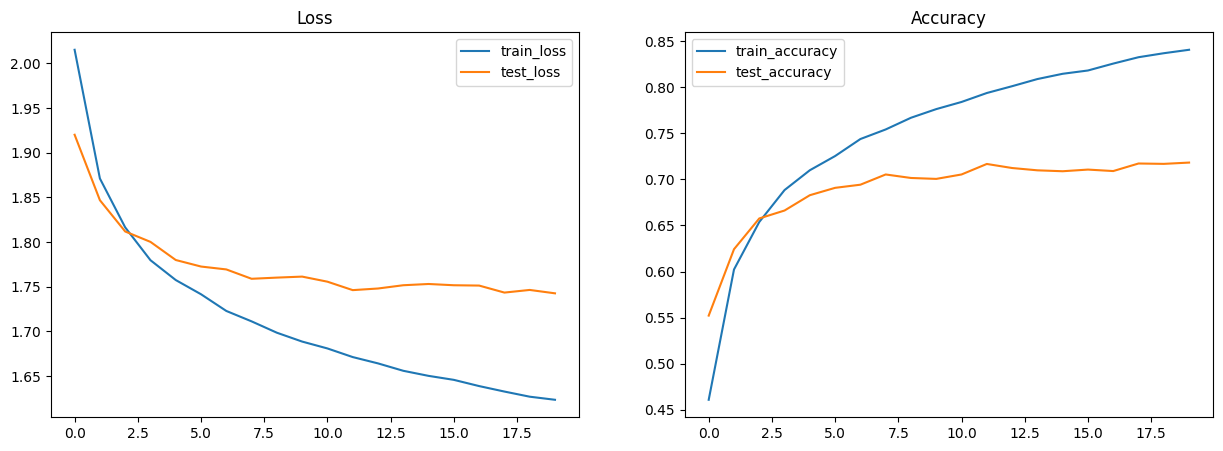

In [11]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

# Perform inference on the test set

In [12]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

In [13]:
import numpy as np

CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [14]:
test_batch = test_ds.as_numpy_iterator().next()
pred = CLASSES[pred_step(model, test_batch)]
pred

array(['airplane', 'ship', 'deer', 'truck', 'deer', 'horse', 'airplane',
       'airplane', 'ship', 'truck', 'deer', 'truck', 'deer', 'ship',
       'dog', 'airplane', 'frog', 'frog', 'frog', 'frog', 'airplane',
       'deer', 'horse', 'airplane', 'automobile', 'airplane', 'truck',
       'cat', 'airplane', 'truck', 'horse', 'horse'], dtype='<U10')

In [15]:
#actual = CLASSES[]

actual = CLASSES[test_batch["label"]]
actual

array(['airplane', 'ship', 'bird', 'truck', 'deer', 'airplane',
       'airplane', 'airplane', 'ship', 'airplane', 'deer', 'truck',
       'deer', 'ship', 'ship', 'ship', 'frog', 'bird', 'frog', 'cat',
       'airplane', 'deer', 'horse', 'airplane', 'automobile', 'airplane',
       'automobile', 'dog', 'bird', 'truck', 'deer', 'horse'],
      dtype='<U10')

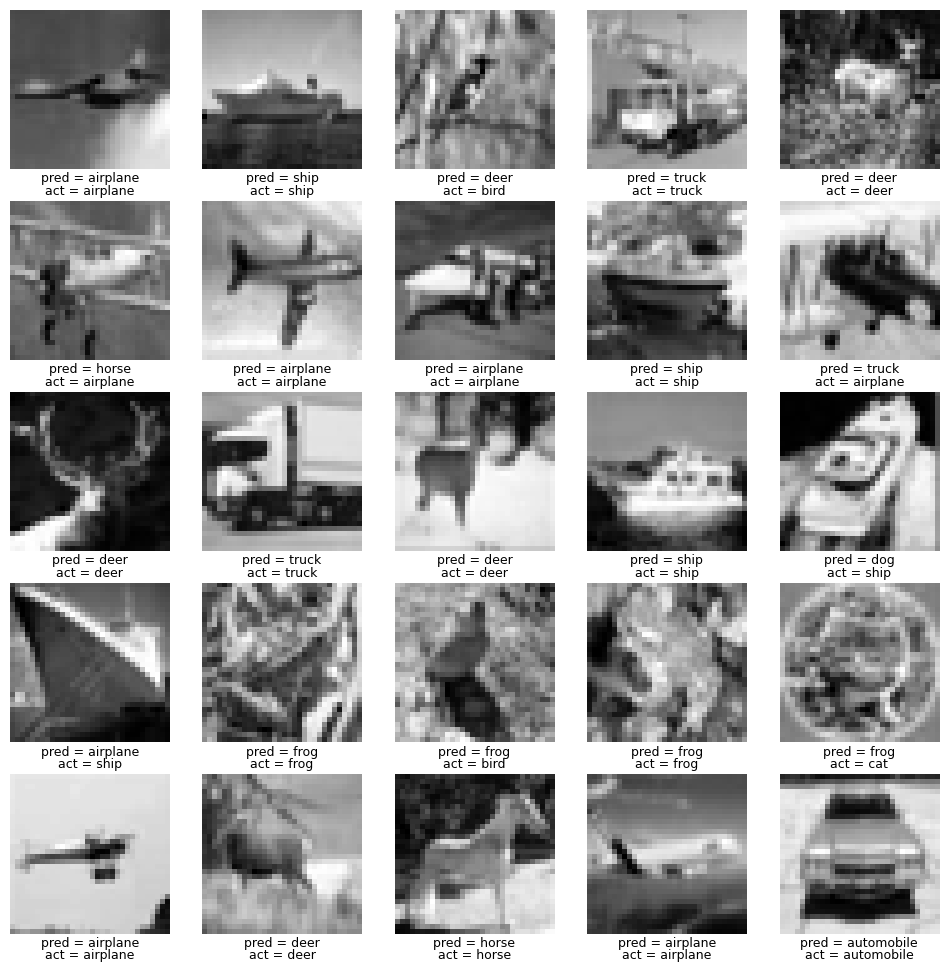

In [16]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for idx, ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.text(0.5, -0.08, 'pred = ' + pred[idx], fontsize=9, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.16, 'act = ' + actual[idx], fontsize=9, ha='center', transform=ax.transAxes)
    ax.imshow(test_batch['image'][idx, ..., 0], cmap='gray')
    ax.axis('off')